In [ ]:
# install dependencies:
!pip install pyyaml==5.1 pycocotools>=2.0.1
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
     |████████████████████████████████| 6.9 MB 709 kB/s 
     |████████████████████████████████| 130 kB 13.9 MB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
     |████████████████████████████████| 145 kB 72.3 MB/s 
     |████████████████████████████████| 74 kB 3.1 MB/s 
     |████████████████████████████████| 749 kB 73.8 MB/s 
     |████████████████████████████████| 843 kB 97.1 MB/s 
     |████████████████████████████████| 112 kB 98.5 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220305-py3-none-any.whl size=61214 sha256=dd8a8b5146224d14b48db79a8fca88690da3c12779dc66c8f1088961315505d3
  Stored in directory: /root/.cache/pip/wheels/b5/b7/6e/43b1693d06fac3633af48db68557513b0a37ab38b0a8b798f9
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=de5d049709b6679ea3da5a60004ce359b27c229129f20a25ab1f05c2135998

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 131.6 MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x556bffcbe000 @  0x7f5fb505a615 0x556bc57433bc 0x556bc582418a 0x556bc57461cd 0x556bc5838b3d 0x556bc57ba458 0x556bc57b502f 0x556bc5747aba 0x556bc57ba2c0 0x556bc57b502f 0x556bc5747aba 0x556bc57b6cd4 0x556bc5839986 0x556bc57b6350 0x556bc5839986 0x556bc57b6350 0x556bc5839986 0x556bc57b6350 0x556bc5747f19 0x556bc578ba79 0x556bc5746b32 0x556bc57ba1dd 0x556bc57b502f 0x556bc5747aba 0x556bc57b6cd4 0x556bc57b502f 0x556bc5747aba 0x556bc57b5eae 0x556bc57479da 0x556bc57b6108 0x556bc57b502f
     |████████████████▌               | 1055.7 MB 1.2 MB/s eta 0:14:10tcmalloc: large alloc 1434370048 bytes == 0x556c44314000 @  0x7f5fb505a615 0x556bc57433bc 0x556bc582418a 0x556bc57461cd 0x556bc5838b3d 0x556bc57ba458 0x556bc57b502f 0x556bc5747aba 0x556bc57ba2c0 0x556bc57b502f 0x556bc5747aba 0x556bc57b6cd4 0x556bc5839986 0x556bc57b

In [ ]:
!pwd # shows current directory
!ls  # shows all files in this directory
!nvidia-smi # shows the specs and the current status of the allocated GPU

/content
'=2.0.1'   sample_data
Mon Mar  7 08:43:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                        

In [ ]:
# import some common libraries
from google.colab.patches import cv2_imshow
from sklearn.metrics import jaccard_score
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import datetime
import random
import json
import cv2
import csv
import os

# import some common pytorch utilities
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch

# import some common detectron2 utilities
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import build_detection_test_loader
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
setup_logger()

<Logger detectron2 (DEBUG)>

In [ ]:
# You need to mount your google drive in order to load the data:
from google.colab import drive
drive.mount('/content/drive')
# Put all the corresponding data files in a data folder and put the data folder in a same directory with this notebook.
# Also create an output directory for your files such as the trained models and the output images.

Mounted at /content/drive


In [ ]:
# Define the location of current directory, which should contain data/train, data/test, and data/train.json.
# TODO: approx 1 line
BASE_DIR = '/content/drive/My Drive/Colab Notebooks/03-cnn-detection-segmentation'
OUTPUT_DIR = '{}/output'.format(BASE_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
'''
# This function should return a list of data samples in which each sample is a dictionary.
# Make sure to select the correct bbox_mode for the data
# For the test data, you only have access to the images, therefore, the annotations should be empty.
# Other values could be obtained from the image files.
# TODO: approx 35 lines
'''

def get_detection_data(set_name):
  data_dirs = '{}/data'.format(BASE_DIR)
  dataset = []
  assert set_name == "test" or set_name == "train"
  file_path = os.path.join(data_dirs,set_name)
  idx = 0
  for filename in os.listdir(file_path):
      record = {}
      file_name = os.path.join(file_path, filename)
      record["file_name"] = file_name
      height, width = cv2.imread(file_name).shape[:2]
      record["height"] = height
      record["width"] = width
      if set_name == "test":
          record["image_id"] = idx
          idx = idx + 1
      dataset.append(record)
  if set_name == "train":
      json_path = os.path.join(data_dirs,'train.json')
      with open(json_path) as f:
          imgs_anns = json.load(f)
      for item in imgs_anns:
          record = list(filter(lambda elem: os.path.basename(elem["file_name"])==item["file_name"],dataset))[0]
          record["image_id"]=item["image_id"]
          if "annotations" not in record:
              record["annotations"]=[]
          annotation ={
              "bbox":item["bbox"],
              "bbox_mode":BoxMode.XYWH_ABS,
              "segmentation":item["segmentation"],
              "category_id":0
          }
          record["annotations"].append(annotation)
  return dataset

In [ ]:
'''
# Remember to add your dataset to DatasetCatalog and MetadataCatalog
# Consdier "data_detection_train" and "data_detection_test" for registration
# You can also add an optional "data_detection_val" for your validation by spliting the training data
# TODO: approx 5 lines
'''
for arg in ["train", "test"]:
    DatasetCatalog.register("data_detection_" + arg, lambda arg = arg: get_detection_data(arg))
    MetadataCatalog.get("data_detection_" + arg).set(thing_classes=["plane"])
plane_metadata = MetadataCatalog.get("data_detection_train")


In [ ]:
'''
# Write a function that returns the cropped image and corresponding mask regarding the target bounding box
# idx is the index of the target bbox in the data
# high-resolution image could be passed or could be load from data['file_name']
# You can use the mask attribute of detectron2.utils.visualizer.GenericMask
#     to convert the segmentation annotations to binary masks
# TODO: approx 10 lines
'''
from PIL import Image, ImageDraw

def get_instance_sample(data, idx, img=None):
  file = data['file_name']
  bbox = data['annotations'][idx]['bbox']
  seg = data['annotations'][idx]['segmentation']
  im = cv2.imread(file)
  path = []
  i = 0
  while i < len(seg[0]):
      path.append((int(seg[0][i]-bbox[0]),int(seg[0][i+1]-bbox[1])))
      i = i + 2
  obj_mask = Image.new("1", [int(bbox[2]),int(bbox[3])], 0)
  draw = ImageDraw.Draw(obj_mask)
  draw.polygon(path, fill=1)
  obj_img = im[int(bbox[1]):int(bbox[1]+bbox[3]),int(bbox[0]):int(bbox[0]+bbox[2]),:]
  obj_img = cv2.resize(obj_img,(256,256))
  obj_mask = obj_mask.resize((256,256))
  #obj_mask = obj_mask * 1.0
  obj_mask = np.asarray(obj_mask) * 1.0
  #print("former img max",np.max(np.max(np.max(obj_img))))
  #print("former mask max",np.max(np.max(np.max(obj_mask))))
  #print(obj_mask)
  #cv2_imshow(obj_mask)
  return obj_img, obj_mask

In [ ]:
'''
# We have provided a template data loader for your segmentation training
# You need to complete the __getitem__() function before running the code
# You may also need to add data augmentation or normalization in here
'''
import matplotlib.pyplot as plt

class PlaneDataset(Dataset):
  def __init__(self, set_name, data_list):
      self.transforms = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),# Converting the image to tensor and change the image format (Channels-Last => Channels-First)
      ])
      self.set_name = set_name
      self.data = data_list
      self.instance_map = []
      for i, d in enumerate(self.data):
        for j in range(len(d['annotations'])):
          self.instance_map.append([i,j])

  '''
  # you can change the value of length to a small number like 10 for debugging of your training procedure and overfeating
  # make sure to use the correct length for the final training
  '''
  def __len__(self):
      return len(self.instance_map)

  def numpy_to_tensor(self, img, mask):
    if self.transforms is not None:
        img = self.transforms(img)
    img = torch.tensor(img, dtype=torch.float)
    mask = torch.tensor(mask, dtype=torch.float)
    mask =torch.reshape(mask,[1,256,256])
#    print("img max",torch.max(img))
#    print("mask max",torch.max(mask))
    return img, mask

  '''
  # Complete this part by using get_instance_sample function
  # make sure to resize the img and mask to a fixed size (for example 128*128)
  # you can use "interpolate" function of pytorch or "numpy.resize"
  # TODO: 5 lines
  '''
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()
    idx = self.instance_map[idx]
    data = self.data[idx[0]]
    img,mask = get_instance_sample(data, idx[1])
    #cv2_imshow(img)
    #cv2_imshow(mask)
    img,mask = self.numpy_to_tensor(img,mask)
    #print("img max",torch.max(img),img.shape)
    #print("mask max",torch.max(mask),mask.shape)
    #cv2_imshow(img.numpy())
    #cv2_imshow(mask.numpy())
    #plt.imshow(img.permute(1,2,0))
    #plt.imshow(mask.permute(1,2,0))
    return img, mask

def get_plane_dataset(set_name='train', batch_size=2):
    my_data_list = DatasetCatalog.get("data_detection_{}".format(set_name))
    dataset = PlaneDataset(set_name, my_data_list)
    loader = DataLoader(dataset, batch_size=batch_size, num_workers=4,
                                              pin_memory=True, shuffle=True)
    return loader, dataset

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

class NestedUNet(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super().__init__()

        filter = [32, 64, 128, 256, 512]

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = ConvBlock(in_channels, filter[0], filter[0])
        self.conv1_0 = ConvBlock(filter[0], filter[1], filter[1])
        self.conv2_0 = ConvBlock(filter[1], filter[2], filter[2])
        self.conv3_0 = ConvBlock(filter[2], filter[3], filter[3])
        self.conv4_0 = ConvBlock(filter[3], filter[4], filter[4])

        self.conv0_1 = ConvBlock(filter[0]+filter[1], filter[0], filter[0])
        self.conv1_1 = ConvBlock(filter[1]+filter[2], filter[1], filter[1])
        self.conv2_1 = ConvBlock(filter[2]+filter[3], filter[2], filter[2])
        self.conv3_1 = ConvBlock(filter[3]+filter[4], filter[3], filter[3])

        self.conv0_2 = ConvBlock(filter[0]*2+filter[1], filter[0], filter[0])
        self.conv1_2 = ConvBlock(filter[1]*2+filter[2], filter[1], filter[1])
        self.conv2_2 = ConvBlock(filter[2]*2+filter[3], filter[2], filter[2])

        self.conv0_3 = ConvBlock(filter[0]*3+filter[1], filter[0], filter[0])
        self.conv1_3 = ConvBlock(filter[1]*3+filter[2], filter[1], filter[1])

        self.conv0_4 = ConvBlock(filter[0]*4+filter[1], filter[0], filter[0])

        self.final = nn.Conv2d(filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        output = self.final(x0_4)
        return output

In [ ]:
def dice_loss(input, target, smooth = 1.0):
    intersection = (input * target).sum()
    return 1 - ((2. * intersection + smooth) / (input.sum() + target.sum() + smooth))


def BCE_dice_loss(input, target):

    if (input.shape[1] == 1):
        input = torch.squeeze(input, 1)
    if (target.shape[1] == 1):
        target = torch.squeeze(target, 1)

    bce = F.binary_cross_entropy_with_logits(input, target)

    input = torch.sigmoid(input)
    dice = dice_loss(input, target, smooth=0.00001)

    return bce / 2 + dice

In [ ]:
import torch.optim as optim
from torch.utils import data
import tqdm
LR = 0.006
BATCH_SIZE = 4
num_class = 1    # Binary classification: just use 1 out channel.
EPOCHS = 300
Validation_percent = 0.15
input_size = 256
CheckPointDIR = "Custom_Seg"
Save_Interval = 1
#TRAIN_LOG_FILENAME: typing.Final = os.path.join(CHECKPOINT_SAVE_DIR, "loss_log.csv")

SegModel = NestedUNet(num_class)
SegModel = SegModel.cuda()
optimizer = optim.SGD(SegModel.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
loss_function = BCE_dice_loss
data_ttl = get_detection_data("train")
train_val_set = PlaneDataset("train", data_ttl)
n_ttl = len(train_val_set)
n_val = int(Validation_percent * n_ttl)
n_train = n_ttl - n_val
print(f"Patches: total: {n_ttl}, train: {n_train}, val: {n_val}")
train_set, val_set = data.random_split(train_val_set, [n_train, n_val])
train_data_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2)
val_data_loader = data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4)
    # MARK: Loop
for epoch in range(1, EPOCHS + 1):
    SegModel.train()
    train_loss = 0
    train_cnt = 0
    for img, mask in tqdm.tqdm(train_data_loader, desc="Train", unit="patches"):
        img = img.cuda()
        mask = mask.cuda()
        pred = SegModel(img)
        loss = loss_function(pred, mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = train_loss + loss.item()
        train_cnt = train_cnt + img.shape[0]

    scheduler.step()

    SegModel.eval()
    val_loss = 0
    val_cnt = 0

    with torch.no_grad():
        for img, mask in val_data_loader:
            img = img.cuda()
            mask = mask.cuda()
            pred = SegModel(img)
            loss = loss_function(pred, mask)
            val_loss = val_loss + loss.item()
            val_cnt = val_cnt + img.shape[0]
    print(f"{epoch}. train loss: {train_loss / train_cnt}, validation loss: {val_loss / val_cnt}")

    if ((epoch % Save_Interval) == 0):
            checkpoint_filename = os.path.join(CheckPointDIR, f"{epoch}.pth")
            torch.save(SegModel.state_dict(), BASE_DIR+'/'+checkpoint_filename)
            print(f"Checkpoint saved as `{checkpoint_filename}`")



Patches: total: 7980, train: 6783, val: 1197


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [25:03<00:00,  1.13patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

1. train loss: 0.07541521963907906, validation loss: 0.061178259838085905
Checkpoint saved as `Custom_Seg/1.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:51<00:00,  1.14patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

2. train loss: 0.059568062808177814, validation loss: 0.0573368798879078
Checkpoint saved as `Custom_Seg/2.pth`


Train: 100%|██████████| 1695/1695 [24:52<00:00,  1.14patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clon

3. train loss: 0.055490193210520226, validation loss: 0.055164156369491166
Checkpoint saved as `Custom_Seg/3.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:30<00:00,  1.15patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

4. train loss: 0.05318203893844533, validation loss: 0.05399302704054177
Checkpoint saved as `Custom_Seg/4.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train:  64%|██████▎   | 1080/1695 [15:45<06:11,  1.65patches/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c3706c5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_wor

5. train loss: 0.05173273578308149, validation loss: 0.0544281705067708
Checkpoint saved as `Custom_Seg/5.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train:   2%|▏         | 41/1695 [00:38<27:57,  1.01s/patches]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c3706c5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_worke

6. train loss: 0.05009050394977089, validation loss: 0.05370320172288944
Checkpoint saved as `Custom_Seg/6.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train:   1%|▏         | 22/1695 [00:17<14:50,  1.88patches/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c3706c5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_worke

7. train loss: 0.04912900150943119, validation loss: 0.0527308397929505
Checkpoint saved as `Custom_Seg/7.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train:   0%|          | 1/1695 [00:01<55:20,  1.96s/patches]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c3706c5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_worker

8. train loss: 0.04802715850768715, validation loss: 0.05117120410013558
Checkpoint saved as `Custom_Seg/8.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:27<00:00,  1.16patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

9. train loss: 0.04706793607468099, validation loss: 0.05101785787621071
Checkpoint saved as `Custom_Seg/9.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:49<00:00,  1.14patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

10. train loss: 0.04710107030330506, validation loss: 0.050593068081898035
Checkpoint saved as `Custom_Seg/10.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:40<00:00,  1.14patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

11. train loss: 0.04555587818225225, validation loss: 0.050314797929497466
Checkpoint saved as `Custom_Seg/11.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:26<00:00,  1.16patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

12. train loss: 0.04521105356272695, validation loss: 0.05147488278813386
Checkpoint saved as `Custom_Seg/12.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:17<00:00,  1.16patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

13. train loss: 0.04456043302529329, validation loss: 0.04999340150542682
Checkpoint saved as `Custom_Seg/13.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:23<00:00,  1.16patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

14. train loss: 0.04409918769270973, validation loss: 0.05060736302996559
Checkpoint saved as `Custom_Seg/14.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:01<00:00,  1.18patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

15. train loss: 0.04363909435944747, validation loss: 0.049870713747863386
Checkpoint saved as `Custom_Seg/15.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:59<00:00,  1.18patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

16. train loss: 0.04316645342428072, validation loss: 0.04956091870631661
Checkpoint saved as `Custom_Seg/16.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:27<00:00,  1.16patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

17. train loss: 0.04245221726596356, validation loss: 0.05125977725637796
Checkpoint saved as `Custom_Seg/17.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:11<00:00,  1.17patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

18. train loss: 0.042225527698531266, validation loss: 0.052017426479570444
Checkpoint saved as `Custom_Seg/18.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:45<00:00,  1.19patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

19. train loss: 0.04156358676322442, validation loss: 0.05049265417142656
Checkpoint saved as `Custom_Seg/19.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:12<00:00,  1.17patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

20. train loss: 0.04118396527405861, validation loss: 0.05548237805507056
Checkpoint saved as `Custom_Seg/20.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:25<00:00,  1.16patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

21. train loss: 0.040492414413871664, validation loss: 0.0499757595584544
Checkpoint saved as `Custom_Seg/21.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:25<00:00,  1.16patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

22. train loss: 0.040191497522952986, validation loss: 0.04913211797666191
Checkpoint saved as `Custom_Seg/22.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:18<00:00,  1.16patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

23. train loss: 0.03919223685443929, validation loss: 0.04844101545802726
Checkpoint saved as `Custom_Seg/23.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:40<00:00,  1.14patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

24. train loss: 0.03922648919872654, validation loss: 0.04855265484555908
Checkpoint saved as `Custom_Seg/24.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:16<00:00,  1.16patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

25. train loss: 0.03882194079546626, validation loss: 0.05011526457217824
Checkpoint saved as `Custom_Seg/25.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:32<00:00,  1.15patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

26. train loss: 0.038207752471872136, validation loss: 0.05036813568286473
Checkpoint saved as `Custom_Seg/26.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:30<00:00,  1.15patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

27. train loss: 0.03729172449855678, validation loss: 0.04889009273720027
Checkpoint saved as `Custom_Seg/27.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:01<00:00,  1.18patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

28. train loss: 0.03685861249896629, validation loss: 0.05033711682892962
Checkpoint saved as `Custom_Seg/28.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:19<00:00,  1.16patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

29. train loss: 0.03646299852536315, validation loss: 0.05020583281449251
Checkpoint saved as `Custom_Seg/29.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:14<00:00,  1.17patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

30. train loss: 0.036103061729476166, validation loss: 0.05088995471845901
Checkpoint saved as `Custom_Seg/30.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:11<00:00,  1.17patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

31. train loss: 0.036003752745094555, validation loss: 0.050612545257627366
Checkpoint saved as `Custom_Seg/31.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train:  60%|█████▉    | 1015/1695 [14:16<09:33,  1.19patches/s]


KeyboardInterrupt: ignored

Patches: total: 7980, train: 6783, val: 1197


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Train: 100%|██████████

1. train loss: 0.07435081825539426, validation loss: 0.06158669269254375
Checkpoint saved as `Custom_Seg2/1.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:41<00:00,  1.19patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

2. train loss: 0.05935104717129627, validation loss: 0.0585042009298319
Checkpoint saved as `Custom_Seg2/2.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:58<00:00,  1.18patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

3. train loss: 0.055686616748131836, validation loss: 0.057456488207132124
Checkpoint saved as `Custom_Seg2/3.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:06<00:00,  1.17patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

4. train loss: 0.05320157376846029, validation loss: 0.05429004425538025
Checkpoint saved as `Custom_Seg2/4.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:44<00:00,  1.19patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

5. train loss: 0.051454362418271796, validation loss: 0.05415529664917335
Checkpoint saved as `Custom_Seg2/5.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:03<00:00,  1.17patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

6. train loss: 0.050096668273342394, validation loss: 0.05272270093693781
Checkpoint saved as `Custom_Seg2/6.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:50<00:00,  1.18patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

7. train loss: 0.0486473360541208, validation loss: 0.05235441630849472
Checkpoint saved as `Custom_Seg2/7.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:57<00:00,  1.18patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

8. train loss: 0.04753389087640254, validation loss: 0.05219167731951511
Checkpoint saved as `Custom_Seg2/8.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:49<00:00,  1.19patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

9. train loss: 0.04651473343240476, validation loss: 0.05107891824358084
Checkpoint saved as `Custom_Seg2/9.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:39<00:00,  1.19patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

10. train loss: 0.04555099349589826, validation loss: 0.050579405554810095
Checkpoint saved as `Custom_Seg2/10.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:39<00:00,  1.19patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

11. train loss: 0.044764983092481406, validation loss: 0.0507808179286212
Checkpoint saved as `Custom_Seg2/11.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:47<00:00,  1.19patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

12. train loss: 0.043629276483240026, validation loss: 0.05017753274968037
Checkpoint saved as `Custom_Seg2/12.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:47<00:00,  1.19patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

13. train loss: 0.04293005549978014, validation loss: 0.04983897533977909
Checkpoint saved as `Custom_Seg2/13.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:44<00:00,  1.19patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

14. train loss: 0.04201612543743269, validation loss: 0.051110441301229805
Checkpoint saved as `Custom_Seg2/14.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:56<00:00,  1.18patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

15. train loss: 0.04100447566108366, validation loss: 0.050129437146328365
Checkpoint saved as `Custom_Seg2/15.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:47<00:00,  1.19patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

16. train loss: 0.03992509764555985, validation loss: 0.05004036837696631
Checkpoint saved as `Custom_Seg2/16.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:44<00:00,  1.19patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

17. train loss: 0.038813550502149755, validation loss: 0.04970504667447961
Checkpoint saved as `Custom_Seg2/17.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:34<00:00,  1.20patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

18. train loss: 0.037934617974017926, validation loss: 0.05086788901417551
Checkpoint saved as `Custom_Seg2/18.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:20<00:00,  1.21patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

19. train loss: 0.036582086289131184, validation loss: 0.05023496290263922
Checkpoint saved as `Custom_Seg2/19.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:36<00:00,  1.20patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

20. train loss: 0.03533826200264042, validation loss: 0.050299021281476404
Checkpoint saved as `Custom_Seg2/20.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:12<00:00,  1.22patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

21. train loss: 0.034111779020511296, validation loss: 0.05058993722458548
Checkpoint saved as `Custom_Seg2/21.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:44<00:00,  1.19patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

22. train loss: 0.03281620712209064, validation loss: 0.05075180530548096
Checkpoint saved as `Custom_Seg2/22.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:24<00:00,  1.21patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

23. train loss: 0.031292445412603453, validation loss: 0.05289444116794545
Checkpoint saved as `Custom_Seg2/23.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:24<00:00,  1.21patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

24. train loss: 0.0297898574586639, validation loss: 0.05197960408061843
Checkpoint saved as `Custom_Seg2/24.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:43<00:00,  1.19patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

25. train loss: 0.02834017310170649, validation loss: 0.052724814235566055
Checkpoint saved as `Custom_Seg2/25.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:28<00:00,  1.20patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

26. train loss: 0.02681538863959214, validation loss: 0.05327317928490431
Checkpoint saved as `Custom_Seg2/26.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:28<00:00,  1.20patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

27. train loss: 0.025182856592984325, validation loss: 0.054887378737828806
Checkpoint saved as `Custom_Seg2/27.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:15<00:00,  1.21patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

28. train loss: 0.023784898459955302, validation loss: 0.055181192801050515
Checkpoint saved as `Custom_Seg2/28.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:24<00:00,  1.21patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

29. train loss: 0.02234678904094615, validation loss: 0.05592606382375975
Checkpoint saved as `Custom_Seg2/29.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:52<00:00,  1.18patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

30. train loss: 0.02104109319086272, validation loss: 0.056530933004856905
Checkpoint saved as `Custom_Seg2/30.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:33<00:00,  1.20patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

31. train loss: 0.019892637279423114, validation loss: 0.05752783554004985
Checkpoint saved as `Custom_Seg2/31.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:50<00:00,  1.18patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

32. train loss: 0.019061838675037596, validation loss: 0.05806467771829171
Checkpoint saved as `Custom_Seg2/32.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:49<00:00,  1.19patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

33. train loss: 0.018465561303241413, validation loss: 0.05864317513952486
Checkpoint saved as `Custom_Seg2/33.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [24:07<00:00,  1.17patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

34. train loss: 0.018020466130479598, validation loss: 0.058692866138939474
Checkpoint saved as `Custom_Seg2/34.pth`


Train:   0%|          | 0/1695 [00:00<?, ?patches/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train: 100%|██████████| 1695/1695 [23:46<00:00,  1.19patches/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from 

35. train loss: 0.017867593341960315, validation loss: 0.05889908309689533
Checkpoint saved as `Custom_Seg2/35.pth`


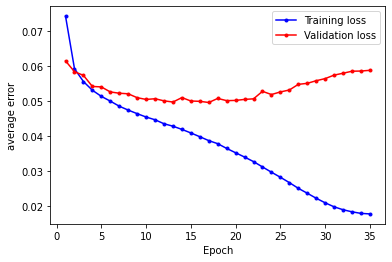

In [ ]:
import torch.optim as optim
from torch.utils import data
import tqdm
import matplotlib.pyplot as plt
LR = 0.006
BATCH_SIZE = 4
num_class = 1    # Binary classification: just use 1 out channel.
EPOCHS = 35
Validation_percent = 0.15
input_size = 256
CheckPointDIR = "Custom_Seg2"
Save_Interval = 1
#TRAIN_LOG_FILENAME: typing.Final = os.path.join(CHECKPOINT_SAVE_DIR, "loss_log.csv")

SegModel = NestedUNet(num_class)
SegModel = SegModel.cuda()
optimizer = optim.SGD(SegModel.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
loss_function = BCE_dice_loss
data_ttl = get_detection_data("train")
train_val_set = PlaneDataset("train", data_ttl)
n_ttl = len(train_val_set)
n_val = int(Validation_percent * n_ttl)
n_train = n_ttl - n_val
print(f"Patches: total: {n_ttl}, train: {n_train}, val: {n_val}")
train_set, val_set = data.random_split(train_val_set, [n_train, n_val])
train_data_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2)
val_data_loader = data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4)
L_trn = []
L_val = []
for epoch in range(1, EPOCHS + 1):
    SegModel.train()
    train_loss = 0
    train_cnt = 0
    for img, mask in tqdm.tqdm(train_data_loader, desc="Train", unit="patches"):
        img = img.cuda()
        mask = mask.cuda()
        pred = SegModel(img)
        loss = loss_function(pred, mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = train_loss + loss.item()
        train_cnt = train_cnt + img.shape[0]

    scheduler.step()

    SegModel.eval()
    val_loss = 0
    val_cnt = 0

    with torch.no_grad():
        for img, mask in val_data_loader:
            img = img.cuda()
            mask = mask.cuda()
            pred = SegModel(img)
            loss = loss_function(pred, mask)
            val_loss = val_loss + loss.item()
            val_cnt = val_cnt + img.shape[0]
    print(f"{epoch}. train loss: {train_loss / train_cnt}, validation loss: {val_loss / val_cnt}")
    L_trn.append(train_loss/train_cnt)
    L_val.append(val_loss/val_cnt)

    if ((epoch % Save_Interval) == 0):
            checkpoint_filename = os.path.join(CheckPointDIR, f"{epoch}.pth")
            torch.save(SegModel.state_dict(), BASE_DIR+'/'+checkpoint_filename)
            print(f"Checkpoint saved as `{checkpoint_filename}`")

x_axis = np.arange(EPOCHS) + 1
plt.plot(x_axis,L_trn,'b.-')
plt.plot(x_axis,L_val,'r.-')
plt.ylabel('average error')
plt.legend(['Training loss','Validation loss'])
plt.xlabel('Epoch')
plt.show()